# MODELLING AND EVALUATION NOTEBOOK 

### Objectives

* This note book helps meet the clients business requirements 2 as listed below  
  - The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.


### Inputs

* The input for this notebook from the test, train and vaidation datasets created in the DataColelction notebook under the below directories
  - Train Dataset - /workspaces/Project5_Mildew_Detection_in_Cherry_Leaves/input/dataset/cherry-leaves/train
  - Test Dataset - /workspaces/Project5_Mildew_Detection_in_Cherry_Leaves/input/dataset/cherry-leaves/test
  - Validate Dataset - /workspaces/Project5_Mildew_Detection_in_Cherry_Leaves/input/dataset/cherry-leaves/validation
  - image shape embeddings
  

### Outputs

* The output will as below 
  - Images distribution plot in train, validation, and test set 
  - Image augmentation 
  - Class indices to change prediction inference in labels
  - Machine learning model creation and training
  - Save model
  - Learning curve plot for model performance 
  - Model evaluation on pickle file
  - Prediction on the random image file

### Importance of this notebook

  - Image augmentation increases the training image data by artificially and temporarily creating training images through different processes,
or a combination of multiple processes, such as random rotation, shifts, shear, and flips, etc, in the computer’s short term memory.
  



---

### Import Libraries
- There is no plt module within matplotlib
- In the majority of the use cases in Data Science, we use a matplotlib submodule called **pyplot** which is imported under the **alias plt**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

### Change working directory 

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Project5_Mildew_Detection_in_Cherry_Leaves/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/Project5_Mildew_Detection_in_Cherry_Leaves'

### Set input directories

Set the Path for Train , Test and Validation datasets

In [5]:
my_data_dir = '/workspaces/Project5_Mildew_Detection_in_Cherry_Leaves/input/dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

- The output directory will be created as **outputs** and a subdirectory will be cretaed to store different versions of the output.
- We set the initial version to v1.
- Every time the cell is clicked the message **"Old version is already available create a new version."** will be displayeed.
- To create a new version, just chaange the version variable to v2

In [29]:
version = 'v1'
file_path = f'/workspaces/Project5_Mildew_Detection_in_Cherry_Leaves/outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
  print('The current version is V1. If you wish to create a new version change the version varibale to V2 and proceed.')
  pass
else:
  os.makedirs(name=file_path)

The current version is V1. If you wish to create a new version change the version varibale to V2 and proceed.


### Set label names

Label names for the images will be **healthy** and **powdery_mildew**

In [7]:
# Set the labels
labels = os.listdir(train_path)
print('Label for the images are',labels)

Label for the images are ['healthy', 'powdery_mildew']


### Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

## Number of images in train, test and validation data
  
- in what ratio should we split the data for Train, Test and Validation?
    - As a rule of thumb, with **supervised learning**
      - 20-30% of the data is used for the test set.
      - 10-20% for  validation sets 
      - Balance being set aside for the train set.
    - The Validation and test sets are similar in  that they are both used to evaluate the model performance.
    - However, they differ only in that the  validation set is used in iteratively tuning the  model for improved performance, through comparison  of different algorithms or hyperparameters.
    - Therefore, as it is no longer considered  to be unseen data by the model,  it can’t be used again as part of the test set.  

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




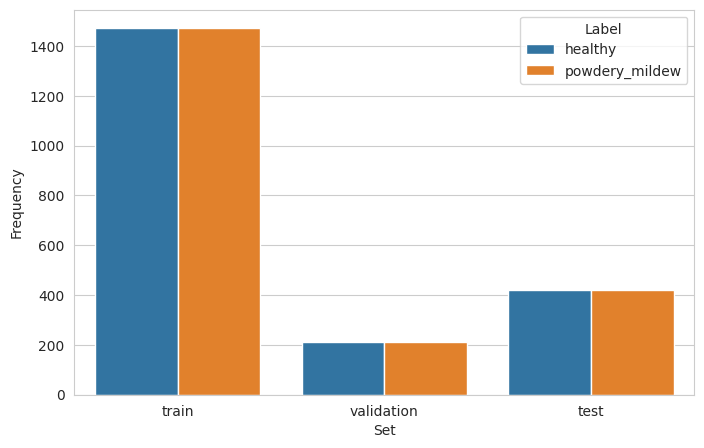

In [28]:
data = []

for folder in ['train', 'validation', 'test']:
    for label in labels:
        # Construct the directory path using os.path.join
        folder_path = os.path.join(my_data_dir, folder, label)
        
        # Calculate the frequency
        freq = len(os.listdir(folder_path))
        
        # Append the data as a dictionary
        data.append({'Set': folder, 'Label': label, 'Frequency': freq})
        
        # Print frequency for each folder and label
        print(f"* {folder} - {label}: {freq} images")

# Convert the list of dictionaries to a DataFrame
df_freq = pd.DataFrame(data)


print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

Image data augmentation
- Augmentation  is a series of data analysis techniques  to increase the quantity of data by adding  slightly modified copies of the existing data
- You can augment the data set by taking an original  image and creating new copies that are
  -  defocused,
  -  flipped, 
  -  rotated,
  -  cropped,
  -  noisy,
  -  stretched or 
  -  the colour modified in some way.
-  These synthetic  images can reduce the risk of **overfitting**  by providing a larger dataset to work with.


Due to its effectiveness and syntax simplicity, another neural network library, known as Keras, was adopted as the interface for TensorFlow from version 2.0.

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-04-13 06:41:06.347398: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intialize ImageDataGenerator

In [17]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

Augment training image dataset

In [18]:
batch_size = 20 # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augment validation image dataset

In [19]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augment test image dataset

In [20]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Plot augmented training image
- We are using **plt.imshow()** to display the NumPy array as an image

In [ ]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

Plot augmented validation and test images
- We are using **plt.imshow()** to display the NumPy array as an image

In [ ]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [ ]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

Save class_indices

In [25]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['/workspaces/Project5_Mildew_Detection_in_Cherry_Leaves/outputs/v1/class_indices.pkl']

# Model creation

## ML model

Import model packages
-   How do you use TensorFlow to create a neural network model?
    -   You use a function in TensorFlow named sequential model.
    -   Tensorflow uses the Sequential Model function to model Neural Networks using different layers arranged to create a network.
    -   Layer examples include Dense layers, convolution layers, Long Short-Term Memory(LSTM), Bi-directional LSTM, dropout layers, batch normalisation layers, and others.
    -   The most commonly used layers are Dense layers, Convolutional Layers, LSTMs for creating Deep neural networks, convolution neural networks and NLP models.
- Due to its effectiveness and syntax simplicity, another neural network library, known as Keras, was adopted as the interface for TensorFlow from version 2.0.
- Tensorflow uses the Sequential model function to model Neural Networks using a different set of layers that are arranged, creating a network.
- To import a given layer, simply type from tensorflow.keras.layers import  ... and choose your layer.

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

MODEL

In [33]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

Model Summary

In [34]:
create_tf_model().summary()

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-13 09:13:46.196255: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29491200 exceeds 10% of free system memory.
2025-04-13 09:13:46.235254: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29491200 exceeds 10% of free system memory.
2025-04-13 09:13:46.244867: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29491200 exceeds 10% of free system memory.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,429,377 (28.34 MB)

 Trainable params: 7,429,377 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

Early Stopping

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

Fit model for model training

In [55]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.7080 - loss: 0.5992 - val_accuracy: 0.9690 - val_loss: 0.0942
Epoch 2/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 2:49 1s/step - accuracy: 0.8500 - loss: 0.3522

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.8500 - loss: 0.3522 - val_accuracy: 0.9929 - val_loss: 0.0292
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.9717 - loss: 0.1059 - val_accuracy: 0.9976 - val_loss: 0.0184
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 1.0000 - loss: 0.0202 - val_accuracy: 0.9976 - val_loss: 0.0090
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.9765 - loss: 0.0640 - val_accuracy: 0.8905 - val_loss: 0.2526
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.9500 - loss: 0.1341 - val_accuracy: 0.8929 - val_loss: 0.2473
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.9831 - loss: 0.0686 - val_accuracy: 0.9929 - val_loss: 0.0510


Save model

In [56]:
model.save('/workspaces/Project5_Mildew_Detection_in_Cherry_Leaves/outputs/v1/mildew_detection_model.h5')

# Model Performance

### Model learning curve

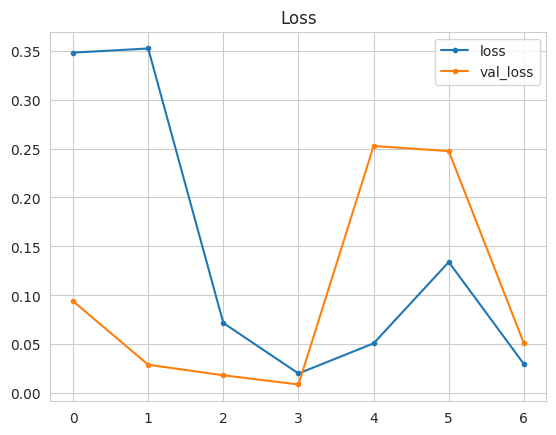

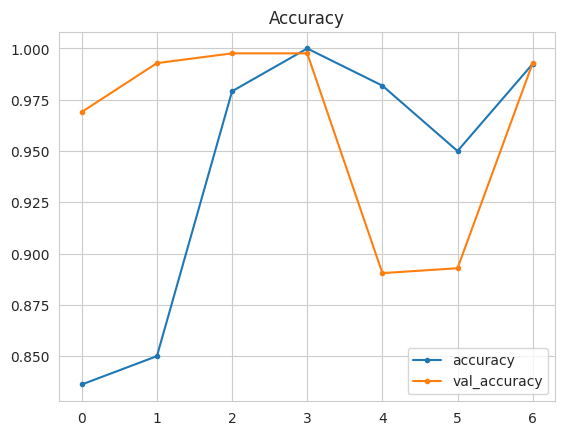

In [57]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

### Model Evaluation

Load saved model

In [58]:
from keras.models import load_model
model = load_model('/workspaces/Project5_Mildew_Detection_in_Cherry_Leaves/outputs/v1/mildew_detection_model.h5')

Evaluate model on test set



In [59]:
evaluation = model.evaluate(test_set)

43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 347ms/step - accuracy: 0.9960 - loss: 0.0293


Save evaluation pickle

In [60]:
joblib.dump(value=evaluation ,
            filename=f"/workspaces/Project5_Mildew_Detection_in_Cherry_Leaves/outputs/v1/evaluation.pkl")

['/workspaces/Project5_Mildew_Detection_in_Cherry_Leaves/outputs/v1/evaluation.pkl']

Predict on new data

Image shape: (256, 256), Image mode: RGB


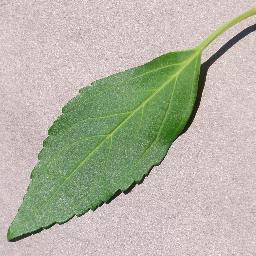

In [61]:
from tensorflow.keras.preprocessing import image

pointer = 66 
label = labels[0] # select healthy or powdery mildew cherry leaves

pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [62]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [63]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1.0
healthy


* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [64]:
import os
try:
    # create here your folder
    os.makedirs(name='/workspaces/Project5_Mildew_Detection_in_Cherry_Leaves/outputs/')
except Exception as e:
    print(e)


[Errno 17] File exists: '/workspaces/Project5_Mildew_Detection_in_Cherry_Leaves/outputs/'
